In [2]:
import os
import torch
from torchvision.transforms import ToTensor, Compose, Resize, Lambda, RandomHorizontalFlip, RandomRotation
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader, random_split
import numpy as np
from matplotlib.pyplot import subplots
from torch import nn
from torchinfo import summary
import torch.nn.functional as F
import lightning as L
from lightning.pytorch import Trainer
from lightning.pytorch.callbacks import ModelCheckpoint


In [3]:
import os

base_path = "archive"
results = {}  # vai conter um dicionário para cada subpasta

for folder in os.listdir(base_path):
    folder_path = os.path.join(base_path, folder)
    if not os.path.isdir(folder_path):
        continue

    # entra na subpasta com o mesmo nome da pasta
    subfolder_path = os.path.join(folder_path, folder)
    if not os.path.isdir(subfolder_path):
        continue

    folder_dict = {}  # dicionário só dessa subpasta

    for file in os.listdir(subfolder_path):
        if file.endswith(".bmp"):
            prefix = file[:-4]  # remove ".bmp"

            cyt_files = sorted(
                f for f in os.listdir(subfolder_path)
                if f.startswith(prefix + "_cyt") and f.endswith(".dat")
            )
            nuc_files = sorted(
                f for f in os.listdir(subfolder_path)
                if f.startswith(prefix + "_nuc") and f.endswith(".dat")
            )

            key = f"{folder}_{file}"  # nome único
            folder_dict[key] = cyt_files + nuc_files

    results[folder] = folder_dict  # adiciona o dicionário da subpasta

# Exemplo de acesso: results["im_Dyskeratotic"]["im_Dyskeratotic_001.bmp"]


In [4]:
import os

base_path = "archive"

for folder in os.listdir(base_path):
    folder_path = os.path.join(base_path, folder)
    if not os.path.isdir(folder_path):
        continue

    subfolder_path = os.path.join(folder_path, folder)
    if not os.path.isdir(subfolder_path):
        continue

    for file in os.listdir(subfolder_path):
        if file.endswith(".dat"):
            dat_path = os.path.join(subfolder_path, file)

            # Lê o conteúdo original
            with open(dat_path, "r") as f:
                content = f.read()

            # Verifica se já tem cabeçalho
            if not content.startswith("x,y"):
                # Adiciona 'x,y' no início + quebra de linha
                with open(dat_path, "w") as f:
                    f.write("x,y\n" + content)

print("✅ Cabeçalho 'x,y' adicionado em todos os .dat que não tinham.")


✅ Cabeçalho 'x,y' adicionado em todos os .dat que não tinham.


In [5]:
print(results["im_Dyskeratotic"]["im_Dyskeratotic_124.bmp"])

['124_cyt01.dat', '124_cyt02.dat', '124_cyt03.dat', '124_cyt04.dat', '124_nuc01.dat', '124_nuc02.dat', '124_nuc03.dat', '124_nuc04.dat']


In [6]:
a = "dsdd.dmp"
print(a[-6:-4])

dd


In [9]:
lista = []

for key in results.keys():
    for subkey in results[key].keys():
        files = results[key][subkey]
        # dicionário para agrupar por número do par (dois caracteres antes de .dat)
        pares_dict = {}
        for f in files:
            num = f[-6:-4]  # pega os dois caracteres antes de ".dat"
            if num not in pares_dict:
                pares_dict[num] = []
            pares_dict[num].append(f)
        
        # agora forma os pares (cyt, nuc)
        for num, group in pares_dict.items():
            cyt_file = next((x for x in group if "_cyt" in x), None)
            nuc_file = next((x for x in group if "_nuc" in x), None)
            if cyt_file and nuc_file:
                lista.append([key, cyt_file, nuc_file])

print(len(lista))

# exemplo de busca
for l in lista:
    if l[1] == "002_cyt02.dat":
        print(l)


4049
['im_Dyskeratotic', '002_cyt02.dat', '002_nuc02.dat']
['im_Superficial-Intermediate', '002_cyt02.dat', '002_nuc02.dat']
['im_Metaplastic', '002_cyt02.dat', '002_nuc02.dat']
['im_Parabasal', '002_cyt02.dat', '002_nuc02.dat']


In [39]:
import numpy as np
import pandas as pd
from PIL import Image

save_dir = "mask"
os.makedirs(save_dir, exist_ok=True)

for l in lista[4000:]:
    img_path = f"archive/{l[0]}/{l[0]}/{l[1][:3]}.bmp"
    cyt = pd.read_csv(f"archive/{l[0]}/{l[0]}/{l[1]}")
    nuc = pd.read_csv(f"archive/{l[0]}/{l[0]}/{l[2]}")

    # lê imagem para pegar dimensões
    img = Image.open(img_path)
    largura, altura = img.size

    # cria imagem vazia (preta)
    mask = np.zeros((altura, largura, 3), dtype=np.uint8)

    # desenha polígonos no array diretamente
    from matplotlib.path import Path

    def draw_polygon(mask, polygon, color):
        polygon = np.array(polygon)
        # cria grade de coordenadas
        yy, xx = np.mgrid[:mask.shape[0], :mask.shape[1]]
        coords = np.vstack((xx.ravel(), yy.ravel())).T
        # máscara do polígono
        p = Path(polygon)
        mask_polygon = p.contains_points(coords).reshape(mask.shape[0], mask.shape[1])
        mask[mask_polygon] = color

    # cores sólidas
    green = [0, 255, 0]
    brown = [165, 42, 42]

    draw_polygon(mask, cyt[[cyt.columns[0], cyt.columns[1]]].values, green)
    draw_polygon(mask, nuc[[nuc.columns[0], nuc.columns[1]]].values, brown)

    out_name = f"{l[0]}{l[1][:3]}_{l[1][-6:-4]}_mask.png"
    out_path = f"{save_dir}/{out_name}"

    Image.fromarray(mask).save(out_path)

    print(out_path)


mask/im_Parabasal001_02_mask.png
mask/im_Parabasal001_03_mask.png
mask/im_Parabasal001_04_mask.png
mask/im_Parabasal001_05_mask.png
mask/im_Parabasal001_06_mask.png
mask/im_Parabasal001_07_mask.png
mask/im_Parabasal001_08_mask.png
mask/im_Parabasal001_09_mask.png
mask/im_Parabasal001_10_mask.png
mask/im_Parabasal001_11_mask.png
mask/im_Parabasal001_12_mask.png
mask/im_Parabasal001_13_mask.png
mask/im_Parabasal082_01_mask.png
mask/im_Parabasal082_02_mask.png
mask/im_Parabasal082_03_mask.png
mask/im_Parabasal091_01_mask.png
mask/im_Parabasal104_01_mask.png
mask/im_Parabasal104_02_mask.png
mask/im_Parabasal104_03_mask.png
mask/im_Parabasal071_01_mask.png
mask/im_Parabasal071_02_mask.png
mask/im_Parabasal071_03_mask.png
mask/im_Parabasal071_04_mask.png
mask/im_Parabasal071_05_mask.png
mask/im_Parabasal071_06_mask.png
mask/im_Parabasal071_07_mask.png
mask/im_Parabasal071_08_mask.png
mask/im_Parabasal038_01_mask.png
mask/im_Parabasal038_02_mask.png
mask/im_Parabasal038_03_mask.png
mask/im_Pa

In [ ]:
import os
from PIL import Image
import numpy as np
from collections import defaultdict

mask_dir = "mask"
output_dir = "mask_combined"
os.makedirs(output_dir, exist_ok=True)

files = [f for f in os.listdir(mask_dir) if f.endswith(".png")]

groups = defaultdict(list)
for f in files:
    prefix = f[:-12]  # ajuste conforme padrão
    groups[prefix].append(f)

for prefix, flist in groups.items():
    combined = None
    for i, f in enumerate(flist):
        path = os.path.join(mask_dir, f)
        img = Image.open(path).convert("RGB")
        img_arr = np.array(img)

        if combined is None:
            combined = img_arr.copy()
        else:
            # redimensiona para mesmo tamanho da primeira imagem
            img_arr = np.array(img.resize((combined.shape[1], combined.shape[0]), resample=Image.NEAREST))

            # sobrescreve pixels que não são pretos
            mask = np.any(img_arr != 0, axis=-1)
            combined[mask] = img_arr[mask]

    out_path = os.path.join(output_dir, f"{prefix}_combined.png")
    Image.fromarray(combined).save(out_path)
    print(f"Salvo: {out_path}")


Salvo: mask_combined/im_Koilocytotic123_combined.png
Salvo: mask_combined/im_Dyskeratotic083_combined.png
Salvo: mask_combined/im_Dyskeratotic093_combined.png
Salvo: mask_combined/im_Parabasal025_combined.png
Salvo: mask_combined/im_Dyskeratotic217_combined.png
Salvo: mask_combined/im_Parabasal028_combined.png
Salvo: mask_combined/im_Parabasal100_combined.png
Salvo: mask_combined/im_Koilocytotic076_combined.png
Salvo: mask_combined/im_Dyskeratotic198_combined.png
Salvo: mask_combined/im_Koilocytotic105_combined.png
Salvo: mask_combined/im_Koilocytotic113_combined.png
Salvo: mask_combined/im_Dyskeratotic066_combined.png
Salvo: mask_combined/im_Koilocytotic233_combined.png
Salvo: mask_combined/im_Parabasal098_combined.png
Salvo: mask_combined/im_Parabasal053_combined.png
Salvo: mask_combined/im_Dyskeratotic011_combined.png
Salvo: mask_combined/im_Dyskeratotic026_combined.png
Salvo: mask_combined/im_Koilocytotic042_combined.png
Salvo: mask_combined/im_Dyskeratotic088_combined.png
Salvo: m

In [ ]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.conv(x)


class Down(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.block = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.block(x)


class Up(nn.Module):
    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        else:
            self.up = nn.ConvTranspose2d(in_channels // 2, in_channels // 2, kernel_size=2, stride=2)

        self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # Ajuste de tamanho para concatenar
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]
        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


# ----- CABEÇA FINAL: convolução 1x1 para gerar classes -----
class OutConv(nn.Module):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, num_classes, kernel_size=1)

    def forward(self, x):
        return self.conv(x)


# ----- U-NET COMPLETA -----
class UNet(nn.Module):
    def __init__(self, n_channels=3, n_classes=1, bilinear=True):
        super().__init__()
        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        factor = 2 if bilinear else 1
        self.down4 = Down(512, 1024 // factor)
        self.up1 = Up(1024, 512 // factor, bilinear)
        self.up2 = Up(512, 256 // factor, bilinear)
        self.up3 = Up(256, 128 // factor, bilinear)
        self.up4 = Up(128, 64, bilinear)
        self.outc = OutConv(64, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits

    

In [12]:
class litUnet(L.LightningModule):
    def __init__(self):
        super().__init__()
        self.model = UNet(n_channels=3, n_classes=3)
        self.loss_fn = nn.CrossEntropyLoss()

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        images, masks = batch
        outputs = self(images)
        loss = self.loss_fn(outputs, masks)
        self.log('train_loss', loss)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        return optimizer
    
    def validation_step(self, batch, batch_idx):
        images, masks = batch
        outputs = self(images)
        loss = self.loss_fn(outputs, masks)
        self.log('val_loss', loss)
        return loss
    
    def test_step(self, batch, batch_idx):
        images, masks = batch
        outputs = self(images)
        loss = self.loss_fn(outputs, masks)
        self.log('test_loss', loss)
        return loss
    
    def predict_step(self, batch, batch_idx, dataloader_idx=0):
        images, _ = batch
        outputs = self(images)
        return torch.sigmoid(outputs)
    

In [13]:
import os
import pandas as pd

base_img_dir = "archive"
mask_dir = "mask_combined"

Cells_Data = pd.DataFrame(columns=["img", "mask"])

for namedir in os.listdir(base_img_dir):
    namedir_path = os.path.join(base_img_dir, namedir)
    subdir_path = os.path.join(namedir_path, namedir)
    
    if not os.path.isdir(subdir_path):
        continue

    for f in os.listdir(subdir_path):
        if f.endswith(".bmp"):
            img_path = os.path.join(subdir_path, f)

            # pega os 3 primeiros caracteres do nome do bmp
            num = f[:3]

            # máscara está diretamente na pasta mask_combined
            mask_name = f"{namedir}{num}_combined.png"
            mask_path = os.path.join(mask_dir, mask_name)

            if os.path.exists(mask_path):
                Cells_Data = pd.concat([Cells_Data, pd.DataFrame({"img":[img_path], "mask":[mask_path]})], ignore_index=True)
            else:
                print(f"⚠️ Máscara não encontrada: {mask_path}")

print("✅ DataFrame criado!")
print(Cells_Data.head())


✅ DataFrame criado!
                                               img  \
0  archive/im_Dyskeratotic/im_Dyskeratotic/118.bmp   
1  archive/im_Dyskeratotic/im_Dyskeratotic/117.bmp   
2  archive/im_Dyskeratotic/im_Dyskeratotic/134.bmp   
3  archive/im_Dyskeratotic/im_Dyskeratotic/214.bmp   
4  archive/im_Dyskeratotic/im_Dyskeratotic/175.bmp   

                                            mask  
0  mask_combined/im_Dyskeratotic118_combined.png  
1  mask_combined/im_Dyskeratotic117_combined.png  
2  mask_combined/im_Dyskeratotic134_combined.png  
3  mask_combined/im_Dyskeratotic214_combined.png  
4  mask_combined/im_Dyskeratotic175_combined.png  


In [32]:
from torch.utils.data import Dataset, random_split
from PIL import Image
from torchvision.transforms import Compose, Resize, ToTensor
import torch
import numpy as np

class Cell_Data(Dataset):
    def __init__(self, df, transform=None):
        """
        df: DataFrame com colunas ["img", "mask"]
        """
        self.img_files = df["img"].tolist()
        self.mask_files = df["mask"].tolist()
        self.transform = transform

        self.color_to_class = {
            (0, 0, 0): 0,        # preto
            (0, 255, 0): 1,      # verde
            (150, 75, 0): 2      # marrom
        }

    def __len__(self):
        return len(self.img_files)

    def __getitem__(self, idx):
        img_path = self.img_files[idx]
        mask_path = self.mask_files[idx]

        # --- imagem RGB normal ---
        image = np.array(Image.open(img_path).convert("RGB")) / 255.0

        # --- máscara RGB ---
        mask_rgb = np.array(Image.open(mask_path).convert("RGB"))

        # Converte RGB -> classe (0, 1, 2)
        mask = np.zeros(mask_rgb.shape[:2], dtype=np.uint8)
        for color, class_idx in self.color_to_class.items():
            mask[np.all(mask_rgb == color, axis=-1)] = class_idx

        # Aplica transformações apenas na imagem (resize + tensor)
        if self.transform:
            image = self.transform(Image.fromarray((image * 255).astype(np.uint8)))
            mask = np.array(Image.fromarray(mask).resize((128, 128), resample=Image.NEAREST))

        # Tensores finais
        image = torch.tensor(np.array(image), dtype=torch.float32)
        mask = torch.tensor(mask, dtype=torch.long)

        return image, mask



transforms = Compose([
    Resize((128, 128)),
    ToTensor()
])


full_dataset = Cell_Data(Cells_Data, transform=transforms)

train_size = int(0.8 * len(full_dataset))
test_size = len(full_dataset) - train_size

train_dataset, test_dataset = random_split(
    full_dataset,
    [train_size, test_size],
    generator=torch.Generator().manual_seed(42)
)

print(f"Train samples: {len(train_dataset)}, Test samples: {len(test_dataset)}")
from PIL import Image
img =Image.open(Cells_Data["mask"][0])
img_array = np.array(img)
if len(img_array.shape) == 3:
    pixels = [tuple(pixel) for row in img_array for pixel in row]
else:  # imagem em grayscale
    pixels = img_array.flatten().tolist()

# Descobrir cores únicas
unique_colors = set(pixels)

print(f"Número de cores únicas: {len(unique_colors)}")
print("Exemplo de cores:", list(unique_colors)[:10])

Train samples: 772, Test samples: 194
Número de cores únicas: 98
Exemplo de cores: [(np.uint8(64), np.uint8(47), np.uint8(16)), (np.uint8(0), np.uint8(45), np.uint8(0)), (np.uint8(0), np.uint8(34), np.uint8(0)), (np.uint8(89), np.uint8(45), np.uint8(22)), (np.uint8(93), np.uint8(45), np.uint8(23)), (np.uint8(94), np.uint8(45), np.uint8(23)), (np.uint8(0), np.uint8(7), np.uint8(0)), (np.uint8(0), np.uint8(73), np.uint8(0)), (np.uint8(0), np.uint8(51), np.uint8(0)), (np.uint8(55), np.uint8(47), np.uint8(14))]


In [ ]:
val_size = int(0.2 * train_size)
train_size_final = train_size - val_size

train_dataset, val_dataset = random_split(
    train_dataset,
    [train_size_final, val_size],
    generator=torch.Generator().manual_seed(42)
)


In [ ]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)


In [ ]:
model = litUnet()

checkpoint_callback = ModelCheckpoint(
    monitor='val_loss',
    dirpath='checkpoints',
    filename='unet-{epoch:02d}-{val_loss:.2f}',
    save_top_k=1,
    mode='min',
)

trainer = Trainer(max_epochs=50, callbacks=[checkpoint_callback], accelerator='auto', precision=16, log_every_n_steps=10)

trainer.fit(model, train_dataloaders=train_loader, val_dataloaders=val_loader)

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type             | Params | Mode 
-----------------------------------------------------
0 | model   | UNet             | 13.4 M | train
1 | loss_fn | CrossEntropyLoss | 0      | train
-----------------------------------------------------
13.4 M    Trainable params
0         Non-trainable params
13.4 M    Total params
53.582    Total estimated model params size (MB)
96        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/tmp/ipykernel_4755/2940731690.py:47: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image = torch.tensor(np.array(image), dtype=torch.float32)


/home/al.igor.alves/Modelos/Cervical_/.venv/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:433: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.


Epoch 49: 100%|██████████| 20/20 [00:43<00:00,  0.46it/s, v_num=12]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 20/20 [00:43<00:00,  0.46it/s, v_num=12]


In [ ]:
model = litUnet.load_from_checkpoint(checkpoint_callback.best_model_path)
trainer.test(model, dataloaders=test_loader)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/al.igor.alves/Modelos/Cervical_/.venv/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:433: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

/tmp/ipykernel_4755/2940731690.py:47: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image = torch.tensor(np.array(image), dtype=torch.float32)


Testing DataLoader 0: 100%|██████████| 7/7 [00:08<00:00,  0.78it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss          0.0006892876117490232
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.0006892876117490232}]

In [ ]:
model = litUnet()
trainer.predict(model, dataloaders=test_loader)
predict_loader = DataLoader(test_dataset, batch_size=1)
predictions = trainer.predict(model, dataloaders=predict_loader)
predictions

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

/tmp/ipykernel_4755/2940731690.py:47: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image = torch.tensor(np.array(image), dtype=torch.float32)


Predicting DataLoader 0: 100%|██████████| 7/7 [00:08<00:00,  0.85it/s] 

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 194/194 [00:10<00:00, 18.68it/s]


[tensor([[[[0.5049, 0.5063, 0.5063,  ..., 0.5063, 0.5063, 0.5063],
           [0.5054, 0.5063, 0.5068,  ..., 0.5063, 0.5059, 0.5059],
           [0.5049, 0.5059, 0.5049,  ..., 0.5059, 0.5063, 0.5063],
           ...,
           [0.5044, 0.5044, 0.5039,  ..., 0.5044, 0.5054, 0.5059],
           [0.5039, 0.5034, 0.5029,  ..., 0.5029, 0.5044, 0.5054],
           [0.5049, 0.5039, 0.5034,  ..., 0.5039, 0.5044, 0.5049]],
 
          [[0.5122, 0.5122, 0.5117,  ..., 0.5117, 0.5117, 0.5117],
           [0.5132, 0.5132, 0.5127,  ..., 0.5117, 0.5117, 0.5117],
           [0.5132, 0.5127, 0.5127,  ..., 0.5117, 0.5122, 0.5112],
           ...,
           [0.5137, 0.5132, 0.5132,  ..., 0.5122, 0.5117, 0.5103],
           [0.5137, 0.5137, 0.5137,  ..., 0.5137, 0.5117, 0.5098],
           [0.5132, 0.5127, 0.5122,  ..., 0.5117, 0.5107, 0.5112]],
 
          [[0.5156, 0.5161, 0.5166,  ..., 0.5161, 0.5156, 0.5156],
           [0.5151, 0.5156, 0.5161,  ..., 0.5156, 0.5156, 0.5156],
           [0.5156, 0.51

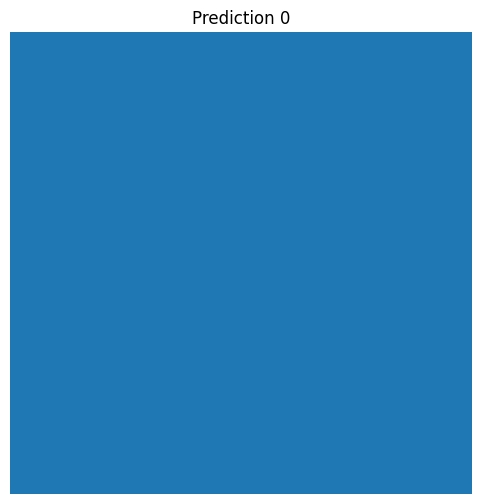

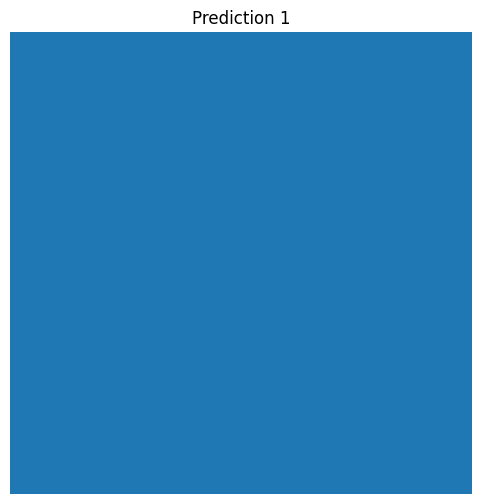

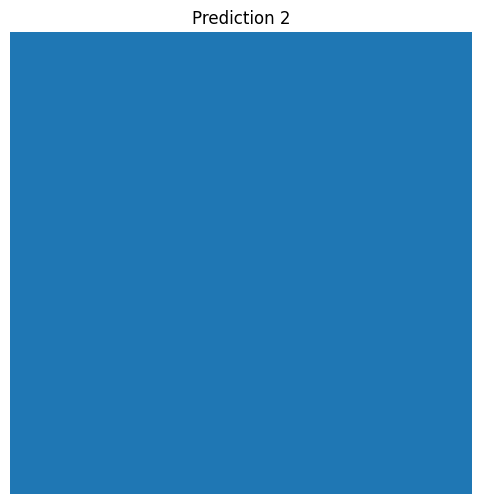

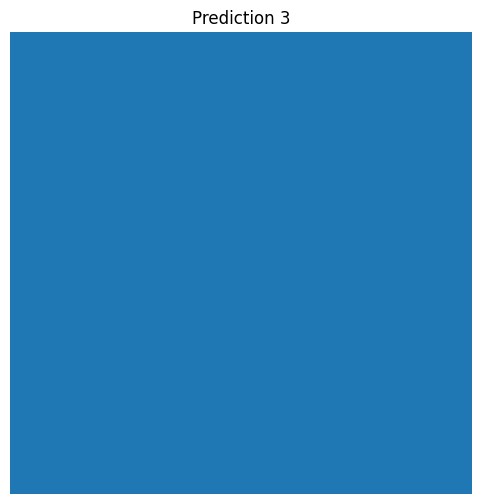

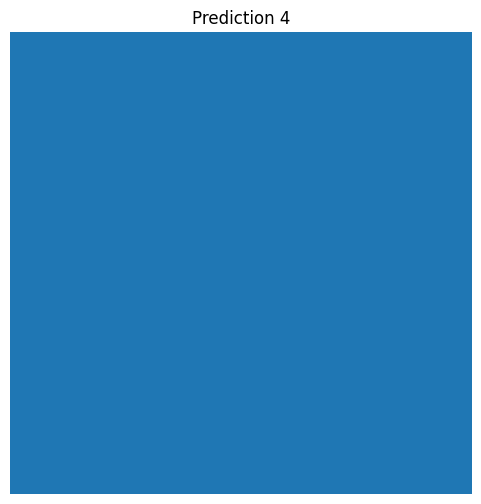

In [ ]:
num_to_show = 5

for i in range(num_to_show):
    pred = predictions[i]
    if isinstance(pred, list):
        pred = pred[0]

    # Remove o batch dimension, se existir
    if pred.ndim == 4:
        pred = pred.squeeze(0)

    # Pega a classe com maior probabilidade
    pred_classes = torch.argmax(pred, dim=0).cpu().numpy()  # [H, W]

    # Visualização
    plt.figure(figsize=(6, 6))
    plt.imshow(pred_classes, cmap='tab20')
    plt.title(f"Prediction {i}")
    plt.axis('off')
    plt.show()


/tmp/ipykernel_4755/2940731690.py:47: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image = torch.tensor(np.array(image), dtype=torch.float32)


TypeError: Invalid shape (3, 128, 128) for image data

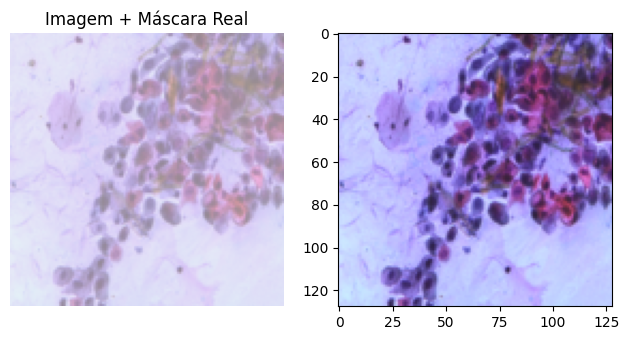

In [ ]:
import matplotlib.pyplot as plt
import torch
import numpy as np

# pega algumas amostras do test_dataset para visualização
num_to_show = 5

for i in range(num_to_show):
    # imagem original e máscara real
    img_tensor, mask_tensor = test_dataset[i]
    
    # converte para numpy
    img_np = img_tensor.permute(1, 2, 0).cpu().numpy()  # C,H,W -> H,W,C
    mask_np = mask_tensor.squeeze().cpu().numpy()        # remove channel se tiver 1

    # previsão
    pred = predictions[i]
    if isinstance(pred, list):
        pred = pred[0]
    pred_np = torch.sigmoid(pred).squeeze().cpu().numpy()  # aplica sigmoid se saída não binária

    # binariza máscara prevista (opcional)
    pred_bin = (pred_np > 0.5).astype(np.float32)

    # visualização lado a lado
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 3, 1)
    plt.imshow(img_np)
    plt.imshow(mask_np, cmap='Reds', alpha=0.5)  # máscara real em vermelho semi-transparente
    plt.title("Imagem + Máscara Real")
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(img_np)
    plt.imshow(pred_bin, cmap='Blues', alpha=0.5)  # máscara prevista em azul semi-transparente
    plt.title("Imagem + Predição")
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(img_np)
    plt.imshow(mask_np, cmap='Reds', alpha=0.5)
    plt.imshow(pred_bin, cmap='Blues', alpha=0.3)  # sobreposição real + previsão
    plt.title("Real + Predição")
    plt.axis('off')

    plt.show()
